In [1]:
import argparse
from datetime import timedelta
from data.data import get_all_price
import pandas as pd


coins = ['BTC','ETH','EOS', 'BNB','XRP','DOT','UNI','BCH','LTC','SOL','LINK','MATIC','XLM','ETC','THETA']
coins, data = get_all_price(coins, '1d', match=False)

get_all_prices create batch tasks: [['BTC', 'ETH', 'EOS', 'BNB'], ['XRP', 'DOT', 'UNI', 'BCH'], ['LTC', 'SOL', 'LINK', 'MATIC'], ['XLM', 'ETC', 'THETA']]
invalid_coins: {'UNI', 'DOT', 'SOL'}, data size not valid


In [2]:
import pandas as pd
from math import isclose
from util import key, split_data, calc_pos


def reset_alloc(long_allocs:list, short_allocs:list, min_alloc=0.3,max_alloc=0.7):
    all = sum(long_allocs) + sum(short_allocs)
    assert isclose(all, 1), f"{all} should be close to 1"
    if sum(long_allocs) < min_alloc or sum(long_allocs) > max_alloc:
        print(f"portfolio imbalance, reset allocation: {long_allocs}, {short_allocs}")
        return [0.5/len(long_allocs)] * len(long_allocs), [0.5/len(short_allocs)] * len(short_allocs)
    return long_allocs, short_allocs



def backtest(data, long_coins, short_coins, long_allocs=None, short_allocs=None, 
             init_value=1, timeframe='1d', min_alloc=0.3,max_alloc=0.7):
    all_pos = {}
    index = data[long_coins[0]].opentime # time
    allocs1, allocs2 = reset_alloc(long_allocs, short_allocs)
    for coin, alloc in zip(long_coins, allocs1):
        all_pos[coin] = calc_pos(data, coin, init_value * alloc, True)
    for coin, alloc in zip(short_coins, allocs2):
        all_pos[coin] = calc_pos(data, coin, init_value * alloc, False)
    pnls = pd.DataFrame(all_pos)
    pnls.index = index
    pnls['total'] = pnls.sum(axis=1)
    return pnls


def calc_allocs_and_value(pnls, long_coins, short_coins):
    allocs1 = [pnls.iloc[-1][c] for c in long_coins]
    allocs2 = [pnls.iloc[-1][c] for c in short_coins]
    total = sum(allocs1) + sum(allocs2)
    return [a/total for a in allocs1], [a/total for a in allocs2], total


def rebalance(data, long_coins, short_coins, freq_days=30):
    print("split data ...")
    batches = split_data(data, coins, freq=f'{freq_days}D')
    print("============ rebalance backtest ===========")
    value = 1
    allocs1 = [0.5/len(long_coins)] * len(long_coins)
    allocs2 = [0.5/len(short_coins)] * len(short_coins)
    all_pnls = []
    for i, item in enumerate(batches):
        start = item[coins[0]].iloc[0].opentime
        end = item[coins[0]].iloc[-1].opentime
        print(f"batch {i}: {start},{end}")
        print(f"allocations: {allocs1}, {allocs2}")
        pnls = backtest(item, long_coins, short_coins, long_allocs=allocs1, short_allocs=allocs2, init_value=value)
        all_pnls.append(pnls)
        allocs1, allocs2, value = calc_allocs_and_value(pnls, long_coins, short_coins)
    all_pnls = pd.concat(all_pnls)
    return all_pnls

long_coins = ['BTC','ETH']
short_coins = ['BCH','EOS']
pnls = rebalance(data, long_coins, short_coins, freq_days=30)

split data ...
============ rebalance backtest ===========
batch 0: 2020-04-01 00:00:00,2020-04-30 00:00:00
allocations: [0.25, 0.25], [0.25, 0.25]
batch 1: 2020-05-01 00:00:00,2020-05-30 00:00:00
allocations: [0.2917781991309208, 0.3415014870804234], [0.19841482017333073, 0.1683054936153252]
batch 2: 2020-05-31 00:00:00,2020-06-29 00:00:00
allocations: [0.29474899985716757, 0.3608618966515338], [0.18416356430300493, 0.16022553918829371]
batch 3: 2020-06-30 00:00:00,2020-07-29 00:00:00
allocations: [0.28273842838330715, 0.35019387351020287], [0.19177440972716822, 0.17529328837932187]
batch 4: 2020-07-30 00:00:00,2020-08-28 00:00:00
allocations: [0.3126274139254024, 0.4489274166914963], [0.12303590208646585, 0.11540926729663538]
portfolio imbalance, reset allocation: [0.3126274139254024, 0.4489274166914963], [0.12303590208646585, 0.11540926729663538]
batch 5: 2020-08-29 00:00:00,2020-09-27 00:00:00
allocations: [0.24295121459620636, 0.2760296096423588], [0.2523641696175553, 0.2286550061

/Users/yurenji/.pyenv/versions/3.8.1/envs/yurenji3.8/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


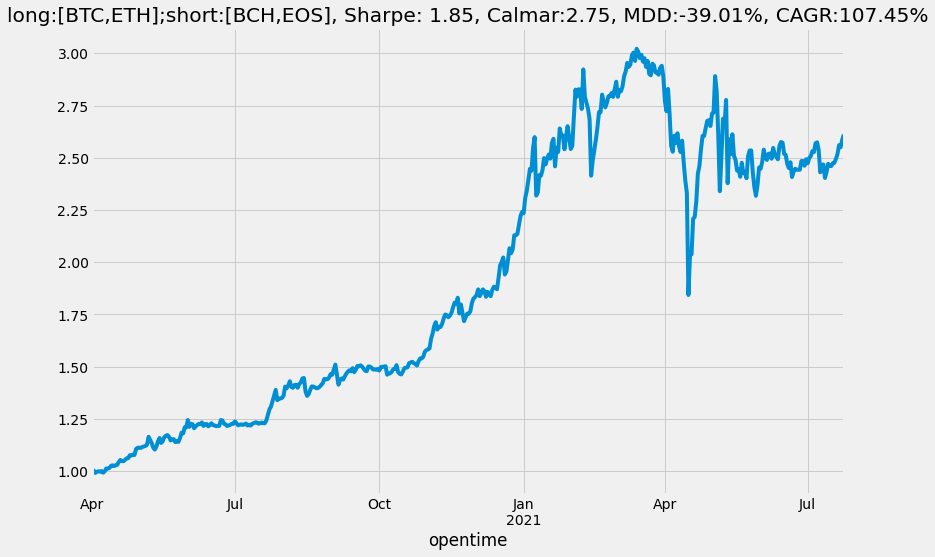

In [3]:
from plot import plot_pnl
from util import key, percentf, stats

sharpe, mdd, cagr, calmar, first, last = stats(pnls, timeframe='1d')
title_key = f"long:[{key(long_coins)}];short:[{key(short_coins)}]"
title = f"{title_key}, Sharpe: {round(sharpe,2)}, Calmar:{round(calmar,2)}, MDD:{percentf(mdd)}, CAGR:{percentf(cagr)}"
plot_pnl(pnls, title)
